In [1]:
# Collection 166 is "EASY Dermoscopy Expert Agreement Study", which is the seminal use case for superpixels
!isic image download --collections 166 ./images

Psst, you're logged out. Logging in with `isic user login` might return more data.


Successfully downloaded 248 images to images/.
Successfully wrote 248 metadata records to images/metadata.csv.
Successfully wrote attributions to images/attribution.txt.
Successfully wrote 2 license(s) to images/licenses.


In [1]:
import io
from typing import BinaryIO
import warnings

import numpy as np
import skimage.io
import skimage.measure
import skimage.morphology
import skimage.segmentation
import skimage.transform

# V1 is an even older "legacy" implementation, relying on a segmentation of the lesion vs normal skin
class ISICSuperpixelV2:
    """
    Create superpixels for ISIC dermoscopic images.

    Adapted from https://github.com/ImageMarkup/isic-archive/blob/master/isic_archive/models/segmentation_helpers/scikit.py
    """
    @classmethod
    def load_image(cls, image_data_stream: BinaryIO | str) -> np.ndarray:
        """
        Load an image into an RGB array.

        :param image_data_stream: A file-like object containing the encoded
        (JPEG, etc.) image data or a file path.
        :return: A Numpy array with the RGB image data.
        """
        image_data = skimage.io.imread(image_data_stream, plugin='pil')

        if len(image_data.shape) == 1 and image_data.shape[0] > 1:
            # Some images seem to have a 2nd (or 3rd+) layer, which should be ignored
            # https://github.com/scikit-image/scikit-image/issues/2154
            # The first element within the result should be the main image
            image_data = image_data[0]

        if len(image_data.shape) == 3 and image_data.shape[2] == 4:
            # cv2.floodFill doesn't work correctly with array views, so copy
            image_data = image_data[:, :, :3].copy()
        return image_data

    @classmethod
    def write_image(cls, image: np.ndarray, encoding: str = 'png', width: int | None = None) -> io.BytesIO:
        if width is not None:
            factor = float(width) / image.shape[1]
            image = skimage.transform.rescale(image, factor)

        image_stream = io.BytesIO()
        with warnings.catch_warnings():
            # Ignore warnings about low contrast images, as masks are often empty
            warnings.filterwarnings('ignore', r'^.* is a low contrast image$', UserWarning)
            # The 'pil' plugin is about 40% faster than the default 'imageio' plugin
            # The 'pil' plugin uses 'format_str' as an argument, not 'format'
            skimage.io.imsave(image_stream, image, plugin='pil', format_str=encoding)
        image_stream.seek(0)
        return image_stream

    @classmethod
    def _slic(cls, image: np.ndarray, num_segments: int | None = None, segment_size: int | None = None):
        compactness = 10.0  # default
        max_num_iter = 10
        sigma = 2.0

        if num_segments and segment_size:
            raise ValueError(
                'Only one of num_segments or segment_size may be set.')
        elif num_segments:
            pass
        elif segment_size:
            num_segments = (image.shape[0] * image.shape[1]) / (segment_size ** 2)
        else:
            raise ValueError('One of num_segments or segment_size must be set.')

        label_image = skimage.segmentation.slic(
            image,
            # convert2lab=True,  # on by default
            n_segments=num_segments,
            compactness=compactness,
            max_num_iter=max_num_iter,
            sigma=sigma,
            enforce_connectivity=True,
            min_size_factor=0.5,
            slic_zero=False,  # tuning this on ignores many other parameters
        )
        return label_image

    @classmethod
    def _uint64_to_rgb(cls, val: np.ndarray) -> np.ndarray:
        return np.dstack((
            val.astype(np.uint8),
            (val >> np.uint64(8)).astype(np.uint8),
            (val >> np.uint64(16)).astype(np.uint8)
        ))

    @classmethod
    def _rgb_to_unit64(cls, val: np.ndarray) -> np.ndarray:
        """
        Decode an RGB representation of a superpixel label into its native scalar value.

        :param val: A single pixel, or a 3-channel image.
                    This is an numpy.ndarray of uint8, with a shape [3] or [n, m, 3].
        """
        return \
            (val[..., 0].astype(np.uint64)) + \
            (val[..., 1].astype(np.uint64) << np.uint64(8)) + \
            (val[..., 2].astype(np.uint64) << np.uint64(16))

    @classmethod
    def superpixel_labels(cls, image: np.ndarray) -> np.ndarray:
        superpixel_labels = cls._slic(image, num_segments=1000)
        return superpixel_labels

In [2]:
import skimage
import PIL

def to_pil(image: np.ndarray) -> PIL.Image:
    """Convert a numpy array image to a PIL image, for better display."""
    return PIL.Image.fromarray(skimage.img_as_ubyte(image))

In [3]:
import math
import numpy as np
import typing
import itk


class ISICSuperpixelV3:
    """
    Create superpixels for ISIC dermoscopic images.

    Adapted from https://github.com/ImageMarkup/isic-archive/blob/master/isic_archive/models/segmentation_helpers/scikit.py
    """
    @classmethod
    def _slic(self, image: itk.Image,
              num_segments: int | None = 1000,
              segment_size: int | None = None):
        if num_segments is not None:
            size_total = image.GetBufferedRegion().GetNumberOfPixels()
            segment_size = int(math.sqrt(size_total / num_segments))

        # parameters are documented in doxygen and code:
        # https://itk.org/Doxygen/html/classitk_1_1SLICImageFilter.html#af5d0b3b4c7e58da1f138948d893ab372
        # https://github.com/InsightSoftwareConsortium/ITK/blob/v5.4rc01/Modules/Segmentation/SuperPixel/include/itkSLICImageFilter.h#L101-L152
        label_image = itk.slic_image_filter(
            image,
            super_grid_size=segment_size,
            maximum_number_of_iterations=20,
            initialization_perturbation=True,
            spatial_proximity_weight=50.0,
            enforce_connectivity=True,
        )
        return label_image

    @classmethod
    def superpixel_labels(self, image: np.ndarray) -> np.ndarray:
        superpixel_labels = self._slic(image, num_segments=1000)
        return superpixel_labels

In [51]:
from pathlib import Path

image_dir = Path('./images')

image_list = list(image_dir.glob('*.JPG'))
image_file = image_list[1]
with image_file.open('rb') as image_stream:
    image = ISICSuperpixelV2.load_image(image_stream)

superpixel_labels = ISICSuperpixelV2.superpixel_labels(image)

In [52]:
image2 = itk.imread(image_file)
superpixel_labels2 = ISICSuperpixelV3.superpixel_labels(image2)

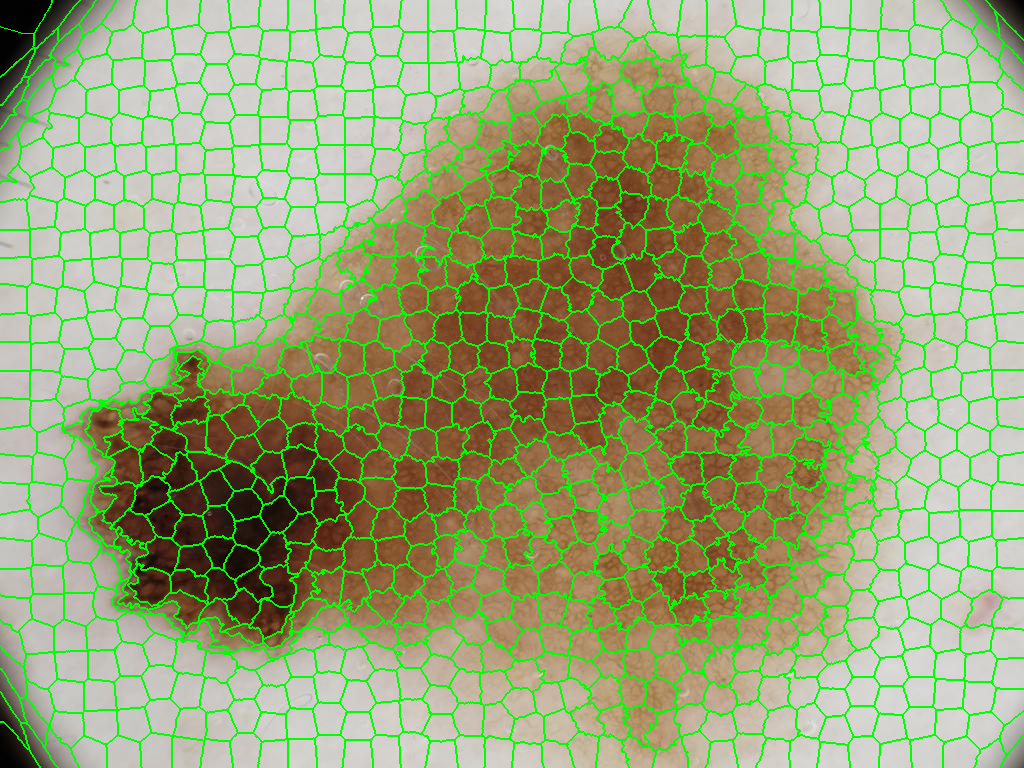

In [53]:
contours_overlay2 = skimage.segmentation.mark_boundaries(
    image, itk.array_view_from_image(superpixel_labels2), color=(0.0, 1.0, 0.0))
# regions_overlay2 = skimage.color.label2rgb(
#     itk.array_view_from_image(superpixel_labels2), image)

display(
    # to_pil(regions_overlay2),
    to_pil(contours_overlay2),
)

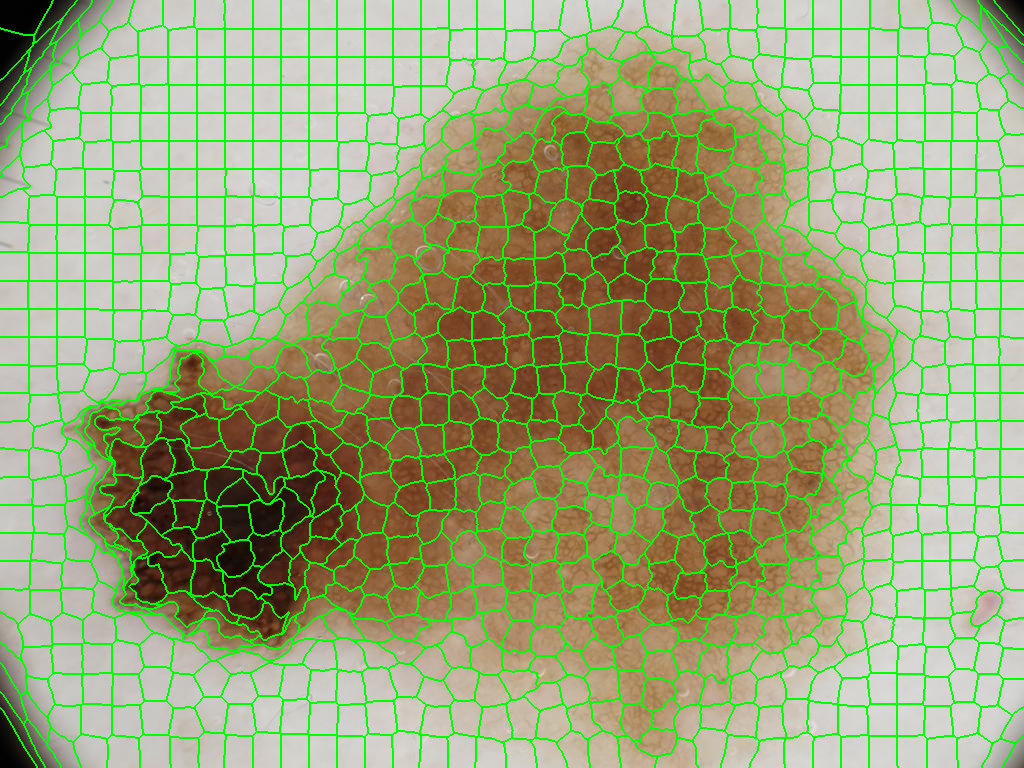

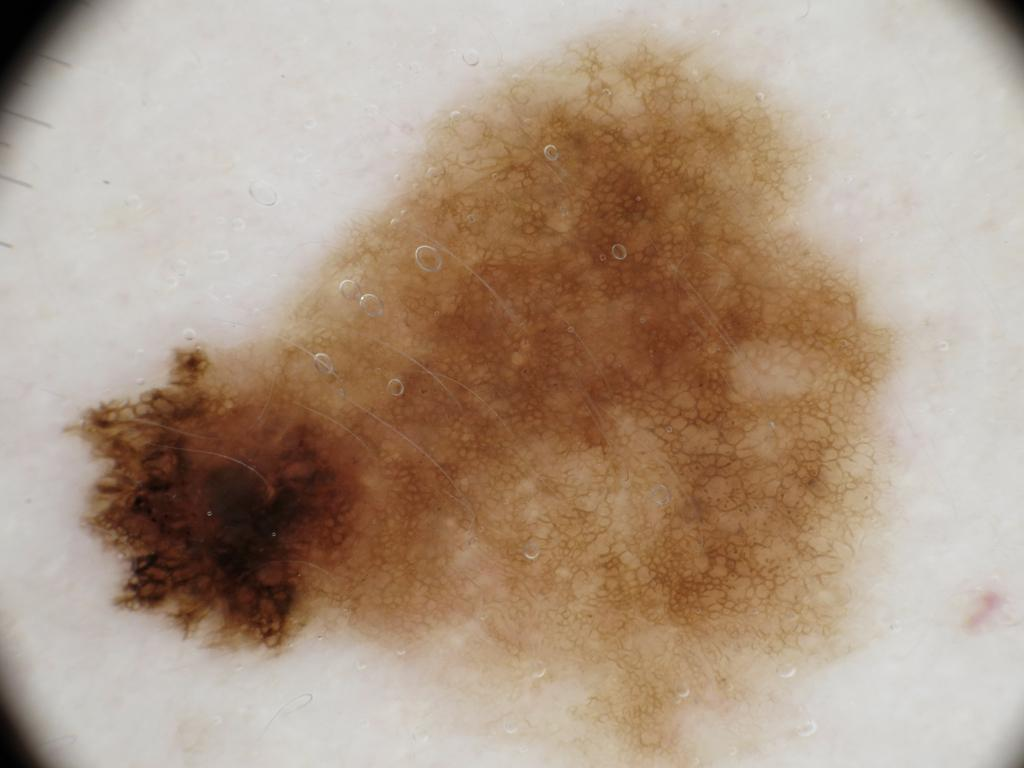

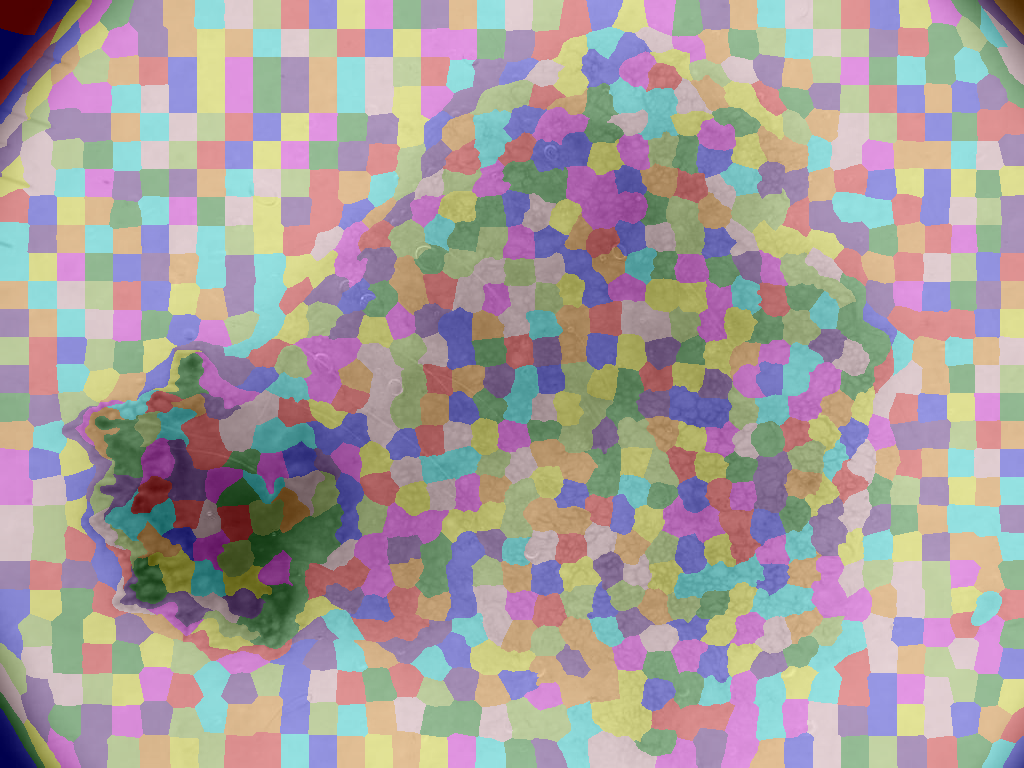

In [54]:
from IPython.display import display

contours_overlay = skimage.segmentation.mark_boundaries(image, superpixel_labels, color=(0.0, 1.0, 0.0))
regions_overlay = skimage.color.label2rgb(superpixel_labels, image)

display(
    to_pil(contours_overlay),
    to_pil(image),
    to_pil(regions_overlay),
)